In [121]:
import pandas as pd
import numpy as np
from pandas_datareader import data
from tensorflow.python.keras.layers import LSTM, Embedding,Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.models import Sequential
import matplotlib.pyplot as plt

In [198]:
#Retrive APPLE stock price\n
tickers = 'AAPL'
data_source = 'iex'
start_date = '2013-01-01'
end_date = '2018-03-31'
panel_data = data.DataReader(tickers, data_source, start_date, end_date)
panel_data =panel_data.reset_index()

train_index=panel_data[panel_data['date']=='2017-12-29'].index[0]
aapl=panel_data['close'].tolist()
stock=panel_data.loc[:, panel_data.columns != 'date'].as_matrix()

5y


In [40]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [p / window[0]- 1 for p in window]
        normalised_data.append(np.array(normalised_window))
    return normalised_data

In [7]:
def get_price(y_val,train_index,stock):
    final=[]
    for i,val in enumerate(y_val):
        final.append((val+1)*stock[train_index-50+i])
    return final

In [8]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [101]:
def load_price_m(price_data,seq_len,split):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(price_data) - sequence_length):
        result.append(price_data[index: index + sequence_length,:])
    result = normalise_windows(result)
    row = split-50
    
    train = result[:int(row)]
    test=result[int(row):]
    np.random.shuffle(train)
    x_train = list(map(lambda x: x[:-1, :],train))
    y_train = list(map(lambda x: x[-1, -2],train))
    x_test = list(map(lambda x: x[:-1, :],test))
    y_test = list(map(lambda x: x[-1, -2],test))
    print(len(y_test))
    x_train = np.array(x_train)
    y_train=np.array(y_train)
    x_test=np.array(x_test)
    y_test=np.array(y_test)
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return [x_train, y_train, x_test, y_test]

In [192]:
def load_price(price, seq_len,split,log):
    if log==True:
        log_return=[]
        price=np.log(price)
        for i in range(len(price)-1):
            log_return.append((price[i+1]-price[i]))
        price=log_return
        row = split-51
        #price=(price-np.mean(price,axis=0))/np.std(price,axis=0)
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(price) - sequence_length):
        result.append(price[index: index + sequence_length])

    if log != True:
        result = normalise_windows(result)
        row = split-seq_len
    
    result = np.array(result)
    # go forward by 50 days
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]
    print(len(y_test))

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return [x_train, y_train, x_test, y_test]

In [11]:
def total_return(real,predicted,log=False):
    real_position=real[:-1]
    if log==False:
        position=[x - y for x, y in zip(real_position, predicted)]
        position=list(map(lambda x: -1 if x<0 else 1,position))
    else:
        position=list(map(lambda x: -1 if x<0 else 1,predicted))
    
    diff=[]
    for i,item in enumerate(real):
        if i !=0:
            diff.append(item-real[i-1])
    return_predict=[x * y for x, y in zip(position, diff)]
    cum_return=[]
    for i in range(len(return_predict)):
        cum_return.append(sum(return_predict[:i+1]))
    return cum_return

In [199]:
#one feature
seq_len=50
x_train, y_train, x_val, y_val = load_price(aapl,seq_len,train_index,False)

61


In [193]:
#multiple features
seq_len=30
x_train, y_train, x_val, y_val=load_price_m(stock,30,train_index)

81


In [200]:
model = Sequential()
model.add(LSTM(30,input_shape=(seq_len, 1),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation('tanh'))

model.add(Dense(16))
model.add(Activation('tanh'))

model.add(Dense(1))
model.add(Activation('tanh'))
model.compile(loss="mse", optimizer="rmsprop")

In [201]:
model.fit(
    x_train,
    y_train,
    batch_size=10,
    epochs=3,
    validation_split=0.1)

Train on 1024 samples, validate on 114 samples
Epoch 1/3
1024/1024 [==============================]1024/1024 [==============================] - 15s 14ms/step - loss: 0.0017 - val_loss: 7.5795e-04

In [202]:
predicted = predict_point_by_point(model, x_val)

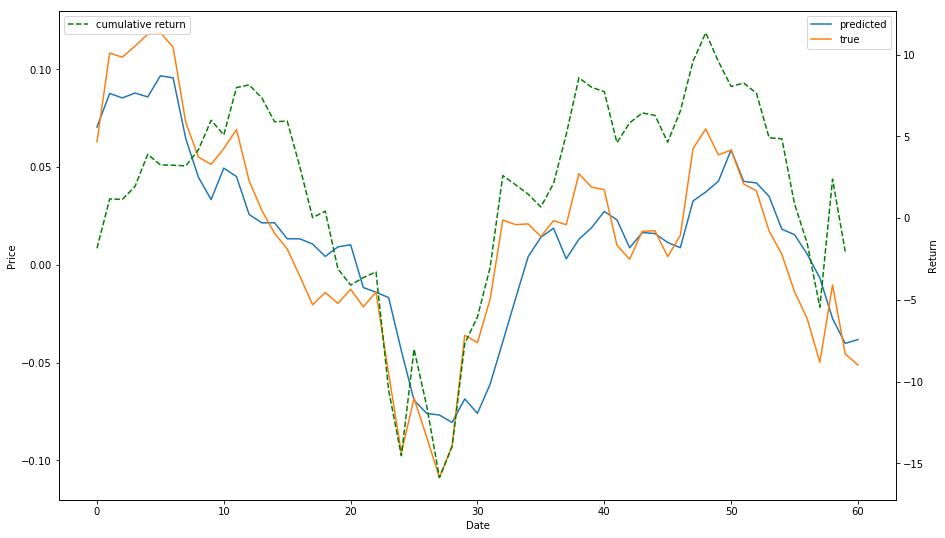

In [203]:
fig, ax1 = plt.subplots(figsize=(15,9))
ax2 = ax1.twinx()
ax1.plot(predicted,label='predicted')
ax1.plot(y_val,label='true')
ax2.plot(total_return(aapl[train_index-1:-2],predicted,log=False),'g--',label='cumulative return')

ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_ylabel('Return')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()

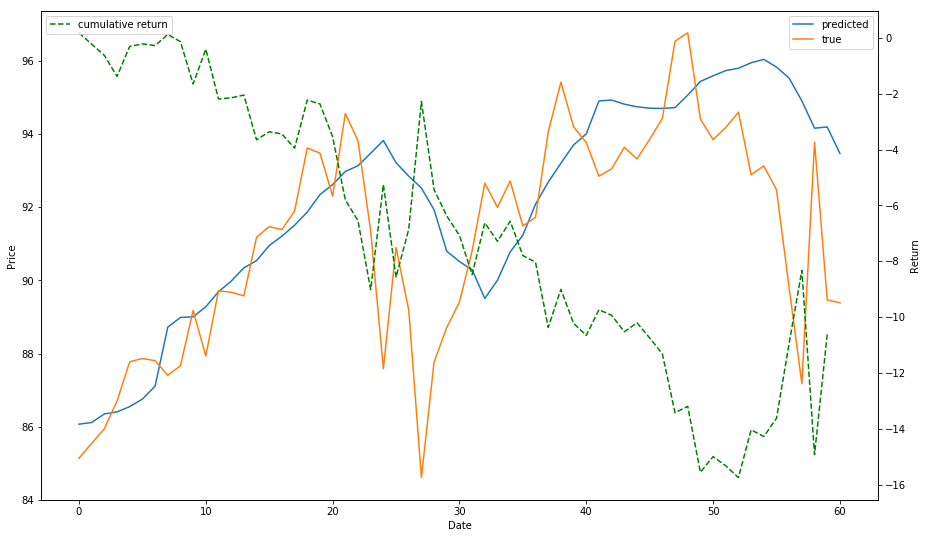

In [17]:
fig, ax1 = plt.subplots(figsize=(15,9))
ax2 = ax1.twinx()
ax1.plot(get_price(predicted,train_index,aapl),label='predicted')
ax1.plot(aapl[train_index:-1],label='true')
ax2.plot(total_return(aapl[train_index-1:-2],get_price(predicted,train_index,aapl)),'g--',label='cumulative return')

ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_ylabel('Return')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()